In [1]:
import os
os.environ['ENV'] = 'prod'
os.environ['REGION'] = 'apse1'
os.environ['TENANT'] ="in"
os.environ['RECO_S3_BUCKET'] = "p13n-reco-offline-prod"
os.environ['COUNTRY_KEY']= "in"
os.environ['AWS_REGION']= "ap-southeast-1"
os.environ['USE_REAL_CMS3']= "True"
os.environ['RECO_CREDENTIAL']= "-----BEGINRSAPRIVATEKEY-----\nMGICAQACEQCdHOlGnxIMWCMzjK2JAg37AgMBAAECEGOIwGTEO9vd3X9+jyiF4NECCQnoqDakDgSm2QIID9sadWN0XvMCCQLiqPkgVKSuIQIIDCAsWM+pJB8CCQG0jbIGCNX9MA==\n-----ENDRSAPRIVATEKEY-----"


import argparse, gc
import json
import os
import numpy as np
import s3fs
import pyarrow
import tensorflow as tf
from tqdm import tqdm

tfv1 = tf.compat.v1
tfv1.disable_v2_behavior()

# Enable memory growth for GPUs to avoid memory fragmentation
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    for device in physical_devices:
        tf.config.experimental.set_memory_growth(device, True)

import tensorflow_addons as tfa
import tensorflow_recommenders_addons as tfra

from common.config.utils import data_path, model_path
from common.config import TENANT
from tpfy.tf_model.tpfy_model_v3_mtl import TpfyModelV3, TpfyMtlModelConfig
from tpfy.etl.schema import TpfyMtlDatasetSchema
from model.parquet_dataset import TFParquetDataset
from tpfy.common import TpfyDataPath
from omegaconf import OmegaConf
from dataclasses import dataclass
from tpfy.train_v3_mtl import make_example_mtl, TpfyTrainConfig, TpfyConfig

S3_TPFY_MODEL_EXPORT = model_path(TpfyDataPath.S3_TPFY_MODEL_EXPORT, TENANT)

def load_model_weights_from_s3(model_name, use_s3=True):
    """
    Load plain weights from S3 or local filesystem
    
    Args:
        model_name: Name of the model (e.g., "my_model/12345678")
        checkpoint: Specific checkpoint to load (None = read from checkpoint file)
        use_s3: If True, load from S3; if False, load from local export/
    
    Returns:
        dict: Plain weights dictionary
    """
    if use_s3:
        filesystem = s3fs.S3FileSystem(use_ssl=False)
        model_path = S3_TPFY_MODEL_EXPORT % model_name
    else:
        filesystem = pyarrow.LocalFileSystem()
        model_path = os.path.join("export", model_name)
    
    # Read checkpoint if not specified
    checkpoint_path = os.path.join(model_path, "checkpoint")
    print(f"Reading checkpoint from: {checkpoint_path}")

    if not filesystem.exists(checkpoint_path):
        raise FileNotFoundError(f"Checkpoint file not found: {checkpoint_path}")

    with filesystem.open(checkpoint_path, "r") as f:
        checkpoint = f.read().strip()
    print(f"Using checkpoint: {checkpoint}")
    
    # Load weights
    weights_path = os.path.join(model_path, checkpoint, "plain_weights.npz")
    print(f"Loading weights from: {weights_path}")
    
    if not filesystem.exists(weights_path):
        raise FileNotFoundError(f"Weights file not found: {weights_path}")
    
    with filesystem.open(weights_path, "rb") as f:
        plain_weights = {}
        npz_data = np.load(f)
        for k, v in npz_data.items():
            plain_weights[k] = v
    
    print(f"Loaded {len(plain_weights)} weight tensors")
    print(f"Weight keys: {list(plain_weights.keys())[:10]}...")  # Show first 10
    
    return plain_weights

class Args:
    """Simple class to hold training arguments (replaces argparse)"""
    def __init__(self):
        # Positional arguments
        self.model_name = "tpfy-v3-mtl-r2"
        self.date = "2026-02-06"  # Training date
        self.val_date = "2026-02-06"  # Validation date
        
        # Optional arguments
        self.conf = None
        self.max_epoch = None
        self.val_days = 1
        self.click_ns = 0.08
        self.variant = "cms3"
        self.num_workers = 4
        self.repeat = 1
        self.eval_freq = None
        self.lr = 1e-4
        self.batch_size = 512
        self.click_weight = 1.0
        self.watch_weight = 1.0
        self.upload = False  # Set to False if you don't want to upload to S3
        self.reload_local_model = None
        self.reload_s3_model = "tpfy-v3-mtl-r2"  # Set to None if starting fresh
        self.extract_activations = True
        self.output = None
        self.clear_nn = False
        self.ckpt = None
        self.verbose = False
        self.countries = None

args = Args()

# Display configuration
print("Training Configuration:")
print(f"  Model Name: {args.model_name}")
print(f"  Training Date: {args.date}")
print(f"  Validation Date: {args.val_date}")
print(f"  Variant: {args.variant}")
print(f"  Click NS: {args.click_ns}")
print(f"  Num Workers: {args.num_workers}")
print(f"  Reload Model: {args.reload_s3_model}")
print(f"  Upload: {args.upload}")

import pandas as pd
content_popularity_tag = pd.read_csv('/home/ubuntu/vedansh/code/tpfy-ranker-exploration/content_id_popularity_tag.csv')
content_popularity_tag.drop_duplicates(subset=['sub_title_id'], inplace = True)
content_popularity_tag.reset_index(drop = True, inplace = True)
content_popularity_dict = content_popularity_tag.set_index('sub_title_id')['popularity_tag'].to_dict()

from sklearn.metrics import mean_squared_error
import pickle
    
# def run():
print("="*80)
print("TPFY MODEL INFERENCE FROM PLAIN WEIGHTS")
print("="*80)

# Load configuration
config_name = f"tpfy/tpfy_config/mtl-{TENANT}.yaml"
if not os.path.exists(config_name):
    raise FileNotFoundError(f"Config file {config_name} not found")

hparams: TpfyConfig = OmegaConf.merge(
    OmegaConf.structured(TpfyConfig),
    OmegaConf.load(config_name),
)
print(f"\nLoaded config: {config_name}")

# Override batch size if specified
if args.batch_size:
    hparams.train.batch_size = args.batch_size

batch_size = hparams.train.batch_size
print(f"Batch size: {batch_size}")

# Load dataset
variant = args.variant
if variant and not variant.startswith("-"):
    variant = "-" + variant

data_date = args.date
data_path_str = data_path(
    TpfyDataPath.S3_TPFY_IMPR_V3_AGG_MTL_EXTRACTED_EXAMPLES_VAR, TENANT
) % (variant, data_date)

print(f"\nData path: {data_path_str}")

dataset = TFParquetDataset([data_path_str], TpfyMtlDatasetSchema, shuffle_files=False)
tf_dataset = dataset.create_tf_dataset(batch_size).map(make_example_mtl)

# Create TensorFlow session
session = tfv1.keras.backend.get_session()

# Build model
print(f"\n{'='*80}")
print("BUILDING MODEL")
print(f"{'='*80}")

tpfy_model = TpfyModelV3(
    hparams.model,
    click_ns=args.click_ns,
    enable_random_watch=hparams.train.enable_random_watch,
)

# Create optimizer (needed for compilation, even though we won't train)
optimizer = tfa.optimizers.AdamW(
    weight_decay=0.0,  # Not needed for inference
    learning_rate=0.001,  # Not needed for inference
    epsilon=1e-4,
)
optimizer = tfra.dynamic_embedding.DynamicEmbeddingOptimizer(optimizer)

# Compile model (required to initialize variables)
from model.losses import masked_binary_entropy_loss
from model.metrics import MaskedAUC

loss_dict = {
    "click": masked_binary_entropy_loss(from_logits=True),
    "watch": masked_binary_entropy_loss(from_logits=True),
    "random_watch": masked_binary_entropy_loss(from_logits=False),
    "paywall_view": masked_binary_entropy_loss(from_logits=True),
    "add_watchlist": masked_binary_entropy_loss(from_logits=True),
}
metric_dict = {
    "click": MaskedAUC(from_logits=True),
    "watch": MaskedAUC(from_logits=True),
    "random_watch": MaskedAUC(from_logits=False),
    "paywall_view": MaskedAUC(from_logits=True),
    "add_watchlist": MaskedAUC(from_logits=True),
}

tpfy_model.compile(optimizer=optimizer, loss=loss_dict, metrics=metric_dict)
print("Model compiled")

# ========== BUILD MODEL WITH SAMPLE DATA ==========
print("\nFetching sample batch to build model...")
iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

sample_features, sample_labels, sample_metadata = session.run(next_batch)
print(f"Sample batch loaded: {len(sample_features)} features")

print("Running model forward pass to create weights...")
_ = tpfy_model(sample_features, training=False)

print(f"Model built successfully")
print(f"Total trainable variables: {len(tpfy_model.trainable_variables)}")

# Initialize all variables
print("\nInitializing TensorFlow variables...")
session.run([
    tfv1.global_variables_initializer(),
    tfv1.local_variables_initializer(),
    tfv1.tables_initializer(),
])
# ==================================================

# Load plain weights from S3
print(f"\n{'='*80}")
print("LOADING MODEL WEIGHTS")
print(f"{'='*80}")

plain_weights = load_model_weights_from_s3(
    args.model_name,
    use_s3=True
)
plain_weights_modified = {k.replace('train/', ''): v for k, v in plain_weights.items()}

# Restore weights (NOW the model is built, so this will work)
print("\nRestoring model weights...")
restore_ops = tpfy_model.restore_plain_weights_ops(
    plain_weights_modified,
    clear_nn=args.clear_nn
)
session.run(restore_ops)
print("Weights restored successfully")

# Create NEW iterator (reset to start of dataset)
print(f"\n{'='*80}")
print("RUNNING INFERENCE")
print(f"{'='*80}")

iterator = tf_dataset.make_one_shot_iterator()
next_batch = iterator.get_next()

# Get compress_output tensor (linear_input)
graph = tf.compat.v1.get_default_graph()

# Find the compress_out tensor that is fed to output layer that predicts click / watch
compress_output_tensor = graph.get_tensor_by_name('tpfy_model_v3/deepfm/Relu:0')

from common.time_utils import get_dates_list_forwards
from model.trainer import Trainer, ValData, LearningRateScheduler

validation_dataset_dict = {}
dataset_schema = TpfyMtlDatasetSchema
val_tenant_or_countries = [TENANT]
for country in val_tenant_or_countries:
    for dt in get_dates_list_forwards(args.val_date, args.val_days):
        val_dataset = TFParquetDataset(
            [
                data_path(
                    TpfyDataPath.S3_TPFY_IMPR_V3_DAILY_MTL_EXTRACTED_EXAMPLES,
                    country,
                )
                % (variant, dt)
            ],
            dataset_schema,
            shuffle_files=False,
        )
        validation_dataset_dict[f"{country}-{dt}"] = ValData(
            val_dataset.create_tf_dataset(batch_size)
            .take(hparams.train.eval_steps)
            .cache(f"val_mtl_{country}_{dt}")
            .map(make_example_mtl),
            active_objectives=[
                "click",
                "watch",
                "random_watch",
                "paywall_view",
                "add_watchlist",
            ],
        )

val_it = tfv1.data.make_initializable_iterator(validation_dataset_dict['in-2026-02-06'].tf_dataset)
session.run(val_it.initializer)
val_next = val_it.get_next()

2026-02-09 14:17:27.679554: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2026-02-09 14:17:27.679584: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Instructions for updating:
non-resource variables are not supported in the long term


2026-02-09 14:17:28.652843: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2026-02-09 14:17:28.652866: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2026-02-09 14:17:28.652880: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-10-11-72-173): /proc/driver/nvidia/version does not exist


Training Configuration:
  Model Name: tpfy-v3-mtl-r2
  Training Date: 2026-02-06
  Validation Date: 2026-02-06
  Variant: cms3
  Click NS: 0.08
  Num Workers: 4
  Reload Model: tpfy-v3-mtl-r2
  Upload: False
TPFY MODEL INFERENCE FROM PLAIN WEIGHTS

Loaded config: tpfy/tpfy_config/mtl-in.yaml
Batch size: 512

Data path: s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/agg-mtl-extracted-cms3/2026-02-06
files s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/agg-mtl-extracted-cms3/2026-02-06/part-00000-tid-7617731706831743383-d7b69ff7-441e-4659-95cb-8067a05f5f34-2835-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/agg-mtl-extracted-cms3/2026-02-06/part-00001-tid-7617731706831743383-d7b69ff7-441e-4659-95cb-8067a05f5f34-2909-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/agg-mtl-extracted-cms3/2026-02-06/part-00002-tid-7617731706831743383-d7b69ff7-441e-4659-95cb-8067a05f5f34-3012-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/data

2026-02-09 14:17:29.290073: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.




BUILDING MODEL
Model compiled

Fetching sample batch to build model...
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.


2026-02-09 14:17:29.958984: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2499995000 Hz
2026-02-09 14:17:30.004686: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Sample batch loaded: 9 features
Running model forward pass to create weights...
--------------
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
q Tensor("tpfy_model_v3/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3/deepfm/fwfm/concat:0", shape=(512, 28, 3

2026-02-09 14:17:37.347750: I ./tensorflow_recommenders_addons/dynamic_embedding/core/kernels/lookup_impl/lookup_table_op_cpu.h:143] HashTable on CPU is created on optimized mode: K=l, V=f, DIM=32, init_size=8192


Weights restored successfully

RUNNING INFERENCE
files s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/daily-mtl-extracted-cms3/cd=2026-02-06/part-00000-tid-8936393865993636468-60b9814b-9912-4a53-ab0a-96b98d2823b7-21905-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/daily-mtl-extracted-cms3/cd=2026-02-06/part-00001-tid-8936393865993636468-60b9814b-9912-4a53-ab0a-96b98d2823b7-21902-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/daily-mtl-extracted-cms3/cd=2026-02-06/part-00002-tid-8936393865993636468-60b9814b-9912-4a53-ab0a-96b98d2823b7-21917-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/daily-mtl-extracted-cms3/cd=2026-02-06/part-00003-tid-8936393865993636468-60b9814b-9912-4a53-ab0a-96b98d2823b7-21911-1-c000.snappy.parquet,s3://p13n-reco-offline-prod/dataset_v5/tpfy-impr-v3/daily-mtl-extracted-cms3/cd=2026-02-06/part-00004-tid-8936393865993636468-60b9814b-9912-4a53-ab0a-96b98d2823b7-21925-1-c000.snapp

In [2]:
def get_activations_and_labels(iterator, model, last_layer_tensor):
    features, labels, metadata = session.run(iterator)

    # Run model
    predictions = model(features, training=False)

    # Execute
    pred_values, activation_values = session.run(
        [predictions, last_layer_tensor]
    )

    return activation_values, labels, pred_values, metadata

all_deepFMpredictions = []
all_content_ids = []
all_labels = []
for i in tqdm(range(100)):
    H, y_batch_all_labels, pred_values, metadata = get_activations_and_labels(val_next, tpfy_model, compress_output_tensor)
    y_batch = y_batch_all_labels['click']
    pred_values = pred_values['click']

    mask = (y_batch != -1)

    if not np.any(mask):
        continue

    # H = H[mask.squeeze()]
    y_batch = y_batch[mask].reshape(sum(mask)[0], 1)
    pred_values = pred_values[mask].reshape(sum(mask)[0], 1)

    # H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)
    # variance = np.sqrt(np.diag(H @ A_inv @ H.T))
    # mean = H@theta

    # Append to lists (will concatenate once at the end)
    # all_predictions.append(mean)
    all_deepFMpredictions.append(pred_values)
    all_labels.append(y_batch)
    # all_variances.append(variance)
    all_content_ids.extend([int(content_id) for content_id, mask_bool in zip(metadata['content_id'], mask) if mask_bool])
    # mse_sum += mean_squared_error(y_batch, mean)
    # valid_runs += 1

    # Clean up intermediate variables
    # del H, y_batch, pred_values, mask, variance, mean, y_batch_all_labels, metadata

# if valid_runs == 0:
    # return None, None, None, None, None, None, None

# Concatenate once at the end (more memory efficient)
# predictions = np.concatenate(all_predictions, axis=0) if all_predictions else np.array([])
deepFMpredictions = np.concatenate(all_deepFMpredictions, axis=0)
labels = np.concatenate(all_labels, axis=0) if all_labels else np.array([])
# variances = np.concatenate(all_variances, axis=0) if all_variances else np.array([])

# Clean up lists
# del all_predictions, all_labels, all_variances, all_deepFMpredictions

  0%|                                                                                                                                                              | 0/100 [00:00<?, ?it/s]

--------------
q Tensor("tpfy_model_v3_1/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_1/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_1/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_1/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_1/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_1/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_1/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_1/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_1/deepfm/fwfm/Reshape:0", shape=(512,

  1%|█▌                                                                                                                                                    | 1/100 [00:08<13:13,  8.01s/it]

--------------
q Tensor("tpfy_model_v3_2/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_2/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_2/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_2/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_2/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_2/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_2/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_2/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_2/deepfm/fwfm/Reshape:0", shape=(512,

  2%|███                                                                                                                                                   | 2/100 [00:08<06:00,  3.68s/it]

--------------
q Tensor("tpfy_model_v3_3/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_3/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_3/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_3/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_3/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_3/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_3/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_3/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_3/deepfm/fwfm/Reshape:0", shape=(512,

  3%|████▌                                                                                                                                                 | 3/100 [00:09<03:41,  2.29s/it]

--------------
q Tensor("tpfy_model_v3_4/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_4/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_4/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_4/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_4/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_4/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_4/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_4/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_4/deepfm/fwfm/Reshape:0", shape=(512,

  4%|██████                                                                                                                                                | 4/100 [00:09<02:36,  1.63s/it]

--------------
q Tensor("tpfy_model_v3_5/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_5/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_5/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_5/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_5/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_5/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_5/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_5/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_5/deepfm/fwfm/Reshape:0", shape=(512,

  5%|███████▌                                                                                                                                              | 5/100 [00:10<02:00,  1.27s/it]

--------------
q Tensor("tpfy_model_v3_6/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_6/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_6/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_6/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_6/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_6/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_6/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_6/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_6/deepfm/fwfm/Reshape:0", shape=(512,

  6%|█████████                                                                                                                                             | 6/100 [00:11<01:39,  1.06s/it]

--------------
q Tensor("tpfy_model_v3_7/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_7/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_7/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_7/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_7/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_7/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_7/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_7/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_7/deepfm/fwfm/Reshape:0", shape=(512,

  7%|██████████▌                                                                                                                                           | 7/100 [00:11<01:26,  1.08it/s]

--------------
q Tensor("tpfy_model_v3_8/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_8/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_8/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_8/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_8/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_8/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_8/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_8/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_8/deepfm/fwfm/Reshape:0", shape=(512,

  8%|████████████                                                                                                                                          | 8/100 [00:12<01:19,  1.16it/s]

--------------
q Tensor("tpfy_model_v3_9/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_9/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_9/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_9/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_9/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_9/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_9/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_9/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_9/deepfm/fwfm/Reshape:0", shape=(512,

  9%|█████████████▌                                                                                                                                        | 9/100 [00:13<01:16,  1.19it/s]

--------------
q Tensor("tpfy_model_v3_10/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_10/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_10/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_10/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_10/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_10/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_10/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_10/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_10/deepfm/fwfm/Reshape:0", sh

 10%|██████████████▉                                                                                                                                      | 10/100 [00:14<01:11,  1.26it/s]

--------------
q Tensor("tpfy_model_v3_11/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_11/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_11/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_11/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_11/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_11/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_11/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_11/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_11/deepfm/fwfm/Reshape:0", sh

 11%|████████████████▍                                                                                                                                    | 11/100 [00:14<01:07,  1.31it/s]

--------------
q Tensor("tpfy_model_v3_12/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_12/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_12/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_12/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_12/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_12/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_12/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_12/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_12/deepfm/fwfm/Reshape:0", sh

 12%|█████████████████▉                                                                                                                                   | 12/100 [00:15<01:05,  1.35it/s]

--------------
q Tensor("tpfy_model_v3_13/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_13/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_13/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_13/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_13/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_13/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_13/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_13/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_13/deepfm/fwfm/Reshape:0", sh

 13%|███████████████████▎                                                                                                                                 | 13/100 [00:16<01:04,  1.35it/s]

--------------
q Tensor("tpfy_model_v3_14/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_14/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_14/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_14/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_14/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_14/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_14/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_14/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_14/deepfm/fwfm/Reshape:0", sh

 14%|████████████████████▊                                                                                                                                | 14/100 [00:16<01:01,  1.39it/s]

--------------
q Tensor("tpfy_model_v3_15/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_15/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_15/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_15/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_15/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_15/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_15/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_15/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_15/deepfm/fwfm/Reshape:0", sh

 15%|██████████████████████▎                                                                                                                              | 15/100 [00:17<01:01,  1.39it/s]

--------------
q Tensor("tpfy_model_v3_16/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_16/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_16/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_16/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_16/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_16/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_16/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_16/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_16/deepfm/fwfm/Reshape:0", sh

 16%|███████████████████████▊                                                                                                                             | 16/100 [00:18<01:00,  1.39it/s]

--------------
q Tensor("tpfy_model_v3_17/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_17/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_17/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_17/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_17/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_17/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_17/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_17/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_17/deepfm/fwfm/Reshape:0", sh

 17%|█████████████████████████▎                                                                                                                           | 17/100 [00:19<01:00,  1.38it/s]

--------------
q Tensor("tpfy_model_v3_18/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_18/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_18/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_18/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_18/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_18/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_18/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_18/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_18/deepfm/fwfm/Reshape:0", sh

 18%|██████████████████████████▊                                                                                                                          | 18/100 [00:19<00:59,  1.38it/s]

--------------
q Tensor("tpfy_model_v3_19/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_19/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_19/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_19/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_19/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_19/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_19/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_19/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_19/deepfm/fwfm/Reshape:0", sh

 19%|████████████████████████████▎                                                                                                                        | 19/100 [00:20<00:59,  1.36it/s]

--------------
q Tensor("tpfy_model_v3_20/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_20/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_20/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_20/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_20/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_20/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_20/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_20/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_20/deepfm/fwfm/Reshape:0", sh

 20%|█████████████████████████████▊                                                                                                                       | 20/100 [00:21<00:59,  1.34it/s]

--------------
q Tensor("tpfy_model_v3_21/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_21/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_21/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_21/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_21/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_21/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_21/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_21/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_21/deepfm/fwfm/Reshape:0", sh

 21%|███████████████████████████████▎                                                                                                                     | 21/100 [00:22<00:59,  1.33it/s]

--------------
q Tensor("tpfy_model_v3_22/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_22/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_22/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_22/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_22/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_22/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_22/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_22/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_22/deepfm/fwfm/Reshape:0", sh

 22%|████████████████████████████████▊                                                                                                                    | 22/100 [00:22<00:59,  1.31it/s]

--------------
q Tensor("tpfy_model_v3_23/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_23/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_23/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_23/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_23/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_23/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_23/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_23/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_23/deepfm/fwfm/Reshape:0", sh

 23%|██████████████████████████████████▎                                                                                                                  | 23/100 [00:23<00:55,  1.39it/s]

--------------
q Tensor("tpfy_model_v3_24/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_24/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_24/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_24/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_24/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_24/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_24/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_24/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_24/deepfm/fwfm/Reshape:0", sh

 24%|███████████████████████████████████▊                                                                                                                 | 24/100 [00:24<00:52,  1.43it/s]

--------------
q Tensor("tpfy_model_v3_25/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_25/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_25/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_25/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_25/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_25/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_25/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_25/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_25/deepfm/fwfm/Reshape:0", sh

 25%|█████████████████████████████████████▎                                                                                                               | 25/100 [00:24<00:53,  1.40it/s]

--------------
q Tensor("tpfy_model_v3_26/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_26/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_26/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_26/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_26/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_26/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_26/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_26/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_26/deepfm/fwfm/Reshape:0", sh

 26%|██████████████████████████████████████▋                                                                                                              | 26/100 [00:25<00:51,  1.44it/s]

--------------
q Tensor("tpfy_model_v3_27/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_27/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_27/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_27/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_27/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_27/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_27/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_27/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_27/deepfm/fwfm/Reshape:0", sh

 27%|████████████████████████████████████████▏                                                                                                            | 27/100 [00:26<00:49,  1.47it/s]

--------------
q Tensor("tpfy_model_v3_28/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_28/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_28/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_28/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_28/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_28/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_28/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_28/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_28/deepfm/fwfm/Reshape:0", sh

 28%|█████████████████████████████████████████▋                                                                                                           | 28/100 [00:26<00:48,  1.47it/s]

--------------
q Tensor("tpfy_model_v3_29/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_29/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_29/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_29/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_29/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_29/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_29/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_29/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_29/deepfm/fwfm/Reshape:0", sh

 29%|███████████████████████████████████████████▏                                                                                                         | 29/100 [00:27<00:48,  1.48it/s]

--------------
q Tensor("tpfy_model_v3_30/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_30/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_30/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_30/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_30/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_30/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_30/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_30/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_30/deepfm/fwfm/Reshape:0", sh

 30%|████████████████████████████████████████████▋                                                                                                        | 30/100 [00:28<00:47,  1.47it/s]

--------------
q Tensor("tpfy_model_v3_31/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_31/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_31/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_31/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_31/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_31/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_31/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_31/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_31/deepfm/fwfm/Reshape:0", sh

 31%|██████████████████████████████████████████████▏                                                                                                      | 31/100 [00:28<00:47,  1.46it/s]

--------------
q Tensor("tpfy_model_v3_32/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_32/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_32/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_32/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_32/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_32/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_32/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_32/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_32/deepfm/fwfm/Reshape:0", sh

 32%|███████████████████████████████████████████████▋                                                                                                     | 32/100 [00:29<00:46,  1.45it/s]

--------------
q Tensor("tpfy_model_v3_33/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_33/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_33/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_33/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_33/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_33/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_33/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_33/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_33/deepfm/fwfm/Reshape:0", sh

 33%|█████████████████████████████████████████████████▏                                                                                                   | 33/100 [00:30<00:46,  1.44it/s]

--------------
q Tensor("tpfy_model_v3_34/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_34/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_34/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_34/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_34/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_34/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_34/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_34/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_34/deepfm/fwfm/Reshape:0", sh

 34%|██████████████████████████████████████████████████▋                                                                                                  | 34/100 [00:31<00:46,  1.41it/s]

--------------
q Tensor("tpfy_model_v3_35/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_35/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_35/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_35/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_35/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_35/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_35/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_35/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_35/deepfm/fwfm/Reshape:0", sh

 35%|████████████████████████████████████████████████████▏                                                                                                | 35/100 [00:31<00:46,  1.40it/s]

--------------
q Tensor("tpfy_model_v3_36/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_36/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_36/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_36/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_36/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_36/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_36/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_36/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_36/deepfm/fwfm/Reshape:0", sh

 36%|█████████████████████████████████████████████████████▋                                                                                               | 36/100 [00:32<00:46,  1.38it/s]

--------------
q Tensor("tpfy_model_v3_37/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_37/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_37/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_37/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_37/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_37/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_37/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_37/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_37/deepfm/fwfm/Reshape:0", sh

 37%|███████████████████████████████████████████████████████▏                                                                                             | 37/100 [00:33<00:46,  1.36it/s]

--------------
q Tensor("tpfy_model_v3_38/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_38/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_38/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_38/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_38/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_38/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_38/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_38/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_38/deepfm/fwfm/Reshape:0", sh

 38%|████████████████████████████████████████████████████████▌                                                                                            | 38/100 [00:34<00:45,  1.35it/s]

--------------
q Tensor("tpfy_model_v3_39/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_39/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_39/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_39/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_39/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_39/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_39/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_39/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_39/deepfm/fwfm/Reshape:0", sh

 39%|██████████████████████████████████████████████████████████                                                                                           | 39/100 [00:34<00:45,  1.33it/s]

--------------
q Tensor("tpfy_model_v3_40/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_40/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_40/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_40/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_40/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_40/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_40/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_40/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_40/deepfm/fwfm/Reshape:0", sh

 40%|███████████████████████████████████████████████████████████▌                                                                                         | 40/100 [00:35<00:46,  1.30it/s]

--------------
q Tensor("tpfy_model_v3_41/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_41/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_41/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_41/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_41/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_41/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_41/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_41/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_41/deepfm/fwfm/Reshape:0", sh

 41%|█████████████████████████████████████████████████████████████                                                                                        | 41/100 [00:36<00:45,  1.29it/s]

--------------
q Tensor("tpfy_model_v3_42/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_42/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_42/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_42/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_42/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_42/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_42/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_42/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_42/deepfm/fwfm/Reshape:0", sh

 42%|██████████████████████████████████████████████████████████████▌                                                                                      | 42/100 [00:37<00:45,  1.27it/s]

--------------
q Tensor("tpfy_model_v3_43/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_43/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_43/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_43/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_43/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_43/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_43/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_43/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_43/deepfm/fwfm/Reshape:0", sh

 43%|████████████████████████████████████████████████████████████████                                                                                     | 43/100 [00:38<00:45,  1.26it/s]

--------------
q Tensor("tpfy_model_v3_44/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_44/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_44/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_44/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_44/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_44/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_44/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_44/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_44/deepfm/fwfm/Reshape:0", sh

 44%|█████████████████████████████████████████████████████████████████▌                                                                                   | 44/100 [00:38<00:45,  1.24it/s]

--------------
q Tensor("tpfy_model_v3_45/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_45/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_45/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_45/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_45/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_45/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_45/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_45/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_45/deepfm/fwfm/Reshape:0", sh

 45%|███████████████████████████████████████████████████████████████████                                                                                  | 45/100 [00:39<00:44,  1.24it/s]

--------------
q Tensor("tpfy_model_v3_46/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_46/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_46/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_46/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_46/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_46/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_46/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_46/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_46/deepfm/fwfm/Reshape:0", sh

 46%|████████████████████████████████████████████████████████████████████▌                                                                                | 46/100 [00:40<00:43,  1.23it/s]

--------------
q Tensor("tpfy_model_v3_47/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_47/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_47/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_47/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_47/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_47/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_47/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_47/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_47/deepfm/fwfm/Reshape:0", sh

 47%|██████████████████████████████████████████████████████████████████████                                                                               | 47/100 [00:41<00:43,  1.22it/s]

--------------
q Tensor("tpfy_model_v3_48/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_48/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_48/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_48/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_48/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_48/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_48/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_48/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_48/deepfm/fwfm/Reshape:0", sh

 48%|███████████████████████████████████████████████████████████████████████▌                                                                             | 48/100 [00:42<00:45,  1.14it/s]

--------------
q Tensor("tpfy_model_v3_49/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_49/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_49/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_49/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_49/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_49/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_49/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_49/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_49/deepfm/fwfm/Reshape:0", sh

 49%|█████████████████████████████████████████████████████████████████████████                                                                            | 49/100 [00:43<00:44,  1.15it/s]

--------------
q Tensor("tpfy_model_v3_50/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_50/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_50/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_50/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_50/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_50/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_50/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_50/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_50/deepfm/fwfm/Reshape:0", sh

 50%|██████████████████████████████████████████████████████████████████████████▌                                                                          | 50/100 [00:44<00:43,  1.15it/s]

--------------
q Tensor("tpfy_model_v3_51/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_51/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_51/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_51/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_51/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_51/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_51/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_51/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_51/deepfm/fwfm/Reshape:0", sh

 51%|███████████████████████████████████████████████████████████████████████████▉                                                                         | 51/100 [00:44<00:42,  1.14it/s]

--------------
q Tensor("tpfy_model_v3_52/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_52/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_52/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_52/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_52/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_52/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_52/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_52/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_52/deepfm/fwfm/Reshape:0", sh

 52%|█████████████████████████████████████████████████████████████████████████████▍                                                                       | 52/100 [00:45<00:42,  1.13it/s]

--------------
q Tensor("tpfy_model_v3_53/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_53/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_53/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_53/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_53/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_53/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_53/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_53/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_53/deepfm/fwfm/Reshape:0", sh

 53%|██████████████████████████████████████████████████████████████████████████████▉                                                                      | 53/100 [00:46<00:41,  1.12it/s]

--------------
q Tensor("tpfy_model_v3_54/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_54/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_54/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_54/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_54/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_54/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_54/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_54/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_54/deepfm/fwfm/Reshape:0", sh

 54%|████████████████████████████████████████████████████████████████████████████████▍                                                                    | 54/100 [00:47<00:41,  1.12it/s]

--------------
q Tensor("tpfy_model_v3_55/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_55/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_55/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_55/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_55/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_55/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_55/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_55/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_55/deepfm/fwfm/Reshape:0", sh

 55%|█████████████████████████████████████████████████████████████████████████████████▉                                                                   | 55/100 [00:48<00:40,  1.10it/s]

--------------
q Tensor("tpfy_model_v3_56/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_56/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_56/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_56/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_56/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_56/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_56/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_56/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_56/deepfm/fwfm/Reshape:0", sh

 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                 | 56/100 [00:49<00:40,  1.09it/s]

--------------
q Tensor("tpfy_model_v3_57/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_57/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_57/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_57/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_57/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_57/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_57/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_57/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_57/deepfm/fwfm/Reshape:0", sh

 57%|████████████████████████████████████████████████████████████████████████████████████▉                                                                | 57/100 [00:50<00:39,  1.08it/s]

--------------
q Tensor("tpfy_model_v3_58/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_58/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_58/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_58/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_58/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_58/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_58/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_58/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_58/deepfm/fwfm/Reshape:0", sh

 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                              | 58/100 [00:51<00:39,  1.07it/s]

--------------
q Tensor("tpfy_model_v3_59/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_59/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_59/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_59/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_59/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_59/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_59/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_59/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_59/deepfm/fwfm/Reshape:0", sh

 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                             | 59/100 [00:52<00:38,  1.06it/s]

--------------
q Tensor("tpfy_model_v3_60/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_60/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_60/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_60/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_60/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_60/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_60/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_60/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_60/deepfm/fwfm/Reshape:0", sh

 60%|█████████████████████████████████████████████████████████████████████████████████████████▍                                                           | 60/100 [00:53<00:38,  1.05it/s]

--------------
q Tensor("tpfy_model_v3_61/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_61/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_61/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_61/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_61/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_61/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_61/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_61/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_61/deepfm/fwfm/Reshape:0", sh

 61%|██████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 61/100 [00:54<00:37,  1.04it/s]

--------------
q Tensor("tpfy_model_v3_62/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_62/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_62/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_62/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_62/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_62/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_62/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_62/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_62/deepfm/fwfm/Reshape:0", sh

 62%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 62/100 [00:55<00:36,  1.03it/s]

--------------
q Tensor("tpfy_model_v3_63/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_63/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_63/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_63/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_63/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_63/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_63/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_63/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_63/deepfm/fwfm/Reshape:0", sh

 63%|█████████████████████████████████████████████████████████████████████████████████████████████▊                                                       | 63/100 [00:56<00:36,  1.03it/s]

--------------
q Tensor("tpfy_model_v3_64/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_64/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_64/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_64/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_64/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_64/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_64/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_64/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_64/deepfm/fwfm/Reshape:0", sh

 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                     | 64/100 [00:57<00:35,  1.01it/s]

--------------
q Tensor("tpfy_model_v3_65/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_65/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_65/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_65/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_65/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_65/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_65/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_65/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_65/deepfm/fwfm/Reshape:0", sh

 65%|████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 65/100 [00:58<00:34,  1.00it/s]

--------------
q Tensor("tpfy_model_v3_66/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_66/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_66/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_66/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_66/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_66/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_66/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_66/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_66/deepfm/fwfm/Reshape:0", sh

 66%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 66/100 [00:59<00:34,  1.02s/it]

--------------
q Tensor("tpfy_model_v3_67/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_67/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_67/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_67/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_67/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_67/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_67/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_67/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_67/deepfm/fwfm/Reshape:0", sh

 67%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                 | 67/100 [01:00<00:34,  1.03s/it]

--------------
q Tensor("tpfy_model_v3_68/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_68/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_68/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_68/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_68/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_68/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_68/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_68/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_68/deepfm/fwfm/Reshape:0", sh

 68%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                               | 68/100 [01:01<00:33,  1.04s/it]

--------------
q Tensor("tpfy_model_v3_69/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_69/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_69/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_69/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_69/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_69/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_69/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_69/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_69/deepfm/fwfm/Reshape:0", sh

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                                              | 69/100 [01:02<00:32,  1.04s/it]

--------------
q Tensor("tpfy_model_v3_70/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_70/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_70/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_70/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_70/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_70/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_70/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_70/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_70/deepfm/fwfm/Reshape:0", sh

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                            | 70/100 [01:03<00:31,  1.05s/it]

--------------
q Tensor("tpfy_model_v3_71/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_71/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_71/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_71/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_71/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_71/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_71/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_71/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_71/deepfm/fwfm/Reshape:0", sh

 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 71/100 [01:04<00:30,  1.06s/it]

--------------
q Tensor("tpfy_model_v3_72/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_72/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_72/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_72/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_72/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_72/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_72/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_72/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_72/deepfm/fwfm/Reshape:0", sh

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 72/100 [01:05<00:30,  1.07s/it]

--------------
q Tensor("tpfy_model_v3_73/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_73/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_73/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_73/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_73/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_73/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_73/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_73/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_73/deepfm/fwfm/Reshape:0", sh

 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 73/100 [01:06<00:29,  1.08s/it]

--------------
q Tensor("tpfy_model_v3_74/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_74/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_74/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_74/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_74/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_74/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_74/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_74/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_74/deepfm/fwfm/Reshape:0", sh

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 74/100 [01:08<00:28,  1.10s/it]

--------------
q Tensor("tpfy_model_v3_75/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_75/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_75/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_75/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_75/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_75/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_75/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_75/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_75/deepfm/fwfm/Reshape:0", sh

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                     | 75/100 [01:09<00:27,  1.11s/it]

--------------
q Tensor("tpfy_model_v3_76/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_76/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_76/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_76/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_76/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_76/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_76/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_76/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_76/deepfm/fwfm/Reshape:0", sh

 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 76/100 [01:10<00:27,  1.16s/it]

--------------
q Tensor("tpfy_model_v3_77/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_77/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_77/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_77/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_77/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_77/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_77/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_77/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_77/deepfm/fwfm/Reshape:0", sh

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 77/100 [01:11<00:26,  1.16s/it]

--------------
q Tensor("tpfy_model_v3_78/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_78/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_78/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_78/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_78/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_78/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_78/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_78/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_78/deepfm/fwfm/Reshape:0", sh

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 78/100 [01:12<00:25,  1.16s/it]

--------------
q Tensor("tpfy_model_v3_79/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_79/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_79/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_79/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_79/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_79/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_79/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_79/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_79/deepfm/fwfm/Reshape:0", sh

 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                               | 79/100 [01:14<00:24,  1.16s/it]

--------------
q Tensor("tpfy_model_v3_80/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_80/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_80/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_80/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_80/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_80/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_80/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_80/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_80/deepfm/fwfm/Reshape:0", sh

 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                             | 80/100 [01:15<00:23,  1.17s/it]

--------------
q Tensor("tpfy_model_v3_81/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_81/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_81/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_81/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_81/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_81/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_81/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_81/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_81/deepfm/fwfm/Reshape:0", sh

 81%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 81/100 [01:16<00:22,  1.18s/it]

--------------
q Tensor("tpfy_model_v3_82/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_82/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_82/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_82/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_82/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_82/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_82/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_82/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_82/deepfm/fwfm/Reshape:0", sh

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                          | 82/100 [01:17<00:21,  1.19s/it]

--------------
q Tensor("tpfy_model_v3_83/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_83/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_83/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_83/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_83/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_83/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_83/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_83/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_83/deepfm/fwfm/Reshape:0", sh

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 83/100 [01:18<00:20,  1.19s/it]

--------------
q Tensor("tpfy_model_v3_84/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_84/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_84/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_84/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_84/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_84/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_84/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_84/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_84/deepfm/fwfm/Reshape:0", sh

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 84/100 [01:20<00:19,  1.20s/it]

--------------
q Tensor("tpfy_model_v3_85/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_85/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_85/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_85/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_85/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_85/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_85/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_85/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_85/deepfm/fwfm/Reshape:0", sh

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                      | 85/100 [01:21<00:18,  1.21s/it]

--------------
q Tensor("tpfy_model_v3_86/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_86/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_86/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_86/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_86/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_86/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_86/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_86/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_86/deepfm/fwfm/Reshape:0", sh

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 86/100 [01:22<00:17,  1.22s/it]

--------------
q Tensor("tpfy_model_v3_87/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_87/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_87/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_87/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_87/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_87/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_87/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_87/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_87/deepfm/fwfm/Reshape:0", sh

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 87/100 [01:23<00:16,  1.23s/it]

--------------
q Tensor("tpfy_model_v3_88/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_88/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_88/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_88/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_88/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_88/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_88/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_88/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_88/deepfm/fwfm/Reshape:0", sh

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 88/100 [01:25<00:14,  1.24s/it]

--------------
q Tensor("tpfy_model_v3_89/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_89/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_89/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_89/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_89/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_89/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_89/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_89/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_89/deepfm/fwfm/Reshape:0", sh

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 89/100 [01:26<00:13,  1.25s/it]

--------------
q Tensor("tpfy_model_v3_90/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_90/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_90/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_90/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_90/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_90/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_90/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_90/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_90/deepfm/fwfm/Reshape:0", sh

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████               | 90/100 [01:27<00:12,  1.27s/it]

--------------
q Tensor("tpfy_model_v3_91/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_91/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_91/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_91/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_91/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_91/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_91/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_91/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_91/deepfm/fwfm/Reshape:0", sh

 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 91/100 [01:28<00:11,  1.28s/it]

--------------
q Tensor("tpfy_model_v3_92/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_92/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_92/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_92/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_92/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_92/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_92/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_92/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_92/deepfm/fwfm/Reshape:0", sh

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 92/100 [01:30<00:10,  1.29s/it]

--------------
q Tensor("tpfy_model_v3_93/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_93/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_93/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_93/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_93/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_93/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_93/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_93/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_93/deepfm/fwfm/Reshape:0", sh

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 93/100 [01:31<00:09,  1.29s/it]

--------------
q Tensor("tpfy_model_v3_94/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_94/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_94/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_94/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_94/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_94/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_94/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_94/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_94/deepfm/fwfm/Reshape:0", sh

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 94/100 [01:32<00:07,  1.30s/it]

--------------
q Tensor("tpfy_model_v3_95/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_95/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_95/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_95/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_95/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_95/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_95/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_95/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_95/deepfm/fwfm/Reshape:0", sh

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 95/100 [01:34<00:06,  1.32s/it]

--------------
q Tensor("tpfy_model_v3_96/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_96/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_96/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_96/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_96/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_96/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_96/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_96/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_96/deepfm/fwfm/Reshape:0", sh

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 96/100 [01:35<00:05,  1.33s/it]

--------------
q Tensor("tpfy_model_v3_97/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_97/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_97/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_97/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_97/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_97/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_97/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_97/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_97/deepfm/fwfm/Reshape:0", sh

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 97/100 [01:36<00:04,  1.34s/it]

--------------
q Tensor("tpfy_model_v3_98/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_98/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_98/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_98/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_98/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_98/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_98/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_98/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_98/deepfm/fwfm/Reshape:0", sh

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 98/100 [01:38<00:02,  1.36s/it]

--------------
q Tensor("tpfy_model_v3_99/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_99/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_99/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_99/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_99/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_99/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_99/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_99/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_99/deepfm/fwfm/Reshape:0", sh

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 99/100 [01:39<00:01,  1.38s/it]

--------------
q Tensor("tpfy_model_v3_100/feature_prep/strided_slice:0", shape=(512, 32), dtype=float32)
k Tensor("tpfy_model_v3_100/feature_prep/watched_content_embedding_unpooled:0", shape=(512, ?, 32), dtype=float32)
Kw Tensor("tpfy_model_v3_100/feature_prep/GetSlotFids:1", shape=(512, ?), dtype=float32)
target embedding shape (512, 9, 32)
user embedding shape (512, 27, 32)
target: Tensor("tpfy_model_v3_100/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
user: Tensor("tpfy_model_v3_100/feature_prep/user_feature/user_embeddings:0", shape=(512, 27, 32), dtype=float32)
watched: Tensor("tpfy_model_v3_100/feature_prep/dot_prod_attention_pooling/cond/Merge:0", shape=(512, 32), dtype=float32)
fm_user Tensor("tpfy_model_v3_100/deepfm/fwfm/concat:0", shape=(512, 28, 32), dtype=float32)
fm_item Tensor("tpfy_model_v3_100/feature_prep/target_feature/target_embeddings:0", shape=(512, 9, 32), dtype=float32)
fwfm out Tensor("tpfy_model_v3_100/deepfm/fwfm/Resha

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:41<00:00,  1.01s/it]


In [3]:
content_variances_df = pd.DataFrame({
    'content_id': all_content_ids,
    'deepFMpredictions': deepFMpredictions.flatten()
})
content_variances_df['popularity_tag'] = content_variances_df['content_id'].map(content_popularity_dict)
popularity_deepFMpredictions_dist_stats = content_variances_df.groupby('popularity_tag')['deepFMpredictions'].describe().to_dict()

In [4]:
from collections import Counter
print(Counter([content_popularity_dict.get(x) for x in all_content_ids]))

Counter({'Medium': 12467, 'Low': 12047, None: 7741, 'High': 3297, 'Negligible': 2870})


In [7]:
Counter(labels.flatten())

Counter({1.0: 15509, 0.0: 22913})

In [8]:
15509/(15509+22913)

0.40364895112175314

In [28]:
label_1_dist = dict(Counter([content_popularity_dict.get(x) for x, y in zip(all_content_ids, list(labels.flatten())) if y == 1]))
print(dict(sorted({k: v/sum(label_1_dist.values()) for k, v in label_1_dist.items()}.items(), key=lambda x: x[1], reverse=True)))

{'Medium': 0.3076923076923077, None: 0.2695854020246309, 'Low': 0.2655232445676704, 'High': 0.0939454510284351, 'Negligible': 0.06325359468695596}


In [29]:
label_1_dist = dict(Counter([content_popularity_dict.get(x) for x, y in zip(all_content_ids, list(labels.flatten())) if y == 0]))
print(dict(sorted({k: v/sum(label_1_dist.values()) for k, v in label_1_dist.items()}.items(), key=lambda x: x[1], reverse=True)))

{'Low': 0.34604809496792216, 'Medium': 0.3358355518701174, None: 0.15537031379566185, 'Negligible': 0.08244228167415878, 'High': 0.08030375769213983}


In [13]:
len(list(labels.flatten())), len(all_content_ids)

(38422, 38422)

In [ ]:


def compute_A_b_tf(A, b, iterator, model, last_layer_tensor, logging = False):
    H, y_batch_all_labels, predictions, metadata = get_activations_and_labels(iterator, model, last_layer_tensor)
    y_batch = y_batch_all_labels['click']

    mask = (y_batch != -1)

    if not np.any(mask):
        return A, b

    H = H[mask.squeeze()]
    y_batch = y_batch[mask].reshape(sum(mask)[0], 1)

    H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)

    # Accumulate
    A += H.T @ H
    b += H.T @ y_batch

    assert A.shape == (d, d)
    assert b.shape == (d,1)
    assert np.allclose(A, A.T, atol=1e-6)
    assert np.linalg.eigvalsh(A).min() > 0

    if logging:
        A_inv = np.linalg.inv(A)
        theta = A_inv @ b
        mean = H@theta
        mse_value = mean_squared_error(y_batch, mean)
        return A, b, mse_value

    return A, b, 0

def validation(iterator, model, last_layer_tensor, d=128, runs=10):
    # Use numpy arrays with preallocated size to avoid dynamic list growth
    all_predictions = []
    all_labels = []
    all_variances = []
    all_content_ids = []
    all_deepFMpredictions = []
    mse_sum = 0.0
    valid_runs = 0

    for i in tqdm(range(runs)):
        try:
            H, y_batch_all_labels, pred_values, metadata = get_activations_and_labels(iterator, model, last_layer_tensor)
            y_batch = y_batch_all_labels['click']
            pred_values = pred_values['click']

            mask = (y_batch != -1)

            if not np.any(mask):
                continue

            H = H[mask.squeeze()]
            y_batch = y_batch[mask].reshape(sum(mask)[0], 1)
            pred_values = pred_values[mask].reshape(sum(mask)[0], 1)

            H = H / (np.linalg.norm(H, axis=1, keepdims=True) + 1e-8)
            variance = np.sqrt(np.diag(H @ A_inv @ H.T))
            mean = H@theta

            # Append to lists (will concatenate once at the end)
            all_predictions.append(mean)
            all_deepFMpredictions.append(pred_values)
            all_labels.append(y_batch)
            all_variances.append(variance)
            all_content_ids.extend([int(content_id) for content_id, mask_bool in zip(metadata['content_id'], mask) if mask_bool])
            mse_sum += mean_squared_error(y_batch, mean)
            valid_runs += 1

            # Clean up intermediate variables
            del H, y_batch, pred_values, mask, variance, mean, y_batch_all_labels, metadata

        except tf.errors.OutOfRangeError:
            print(f"Iterator exhausted at run {i}")
            break

    if valid_runs == 0:
        return None, None, None, None, None, None, None

    # Concatenate once at the end (more memory efficient)
    predictions = np.concatenate(all_predictions, axis=0) if all_predictions else np.array([])
    deepFMpredictions = np.concatenate(all_deepFMpredictions, axis=0) if all_predictions else np.array([])
    labels = np.concatenate(all_labels, axis=0) if all_labels else np.array([])
    variances = np.concatenate(all_variances, axis=0) if all_variances else np.array([])

    # Clean up lists
    del all_predictions, all_labels, all_variances, all_deepFMpredictions

    return predictions, deepFMpredictions, labels, variances, all_content_ids, mse_sum / valid_runs

lambda_=1.0
d=128
A = lambda_ * np.eye(d, dtype=np.float64)
b = np.zeros((d, 1), dtype=np.float64)

run = 0
while True:
    try:
        if (run % 10 == 0) and (run):
            # Find the training loss for the current batch
            A, b, mse_value = compute_A_b_tf(A, b, next_batch, tpfy_model, compress_output_tensor, logging=True)

            # Compute A_inv and theta
            A_inv = np.linalg.inv(A)
            theta = A_inv @ b

            # Find the validation evals for 10 runs
            val_results = validation(val_next, tpfy_model, compress_output_tensor, runs=10)

            if val_results[0] is None:
                print(f"Validation failed at run {run}, skipping metrics")
                run += 1
                continue

            predictions, deepFMpredictions, labels, variances, content_ids, val_mse = val_results

            # Create content variance DataFrame (optimized)
            content_variances_df = pd.DataFrame({
                'content_id': content_ids,
                'variances': variances
            })
            content_variances_df['popularity_tag'] = content_variances_df['content_id'].map(content_popularity_dict)
            popularity_variance_dist_stats = content_variances_df.groupby('popularity_tag')['variances'].describe().to_dict()

            # Create content predictions DataFrame (optimized)
            content_predictions_df = pd.DataFrame({
                'content_id': content_ids,
                'predictions': predictions.flatten()
            })
            content_predictions_df['popularity_tag'] = content_predictions_df['content_id'].map(content_popularity_dict)
            popularity_mean_dist_stats = content_predictions_df.groupby('popularity_tag')['predictions'].describe().to_dict()

            # Create content variance DataFrame (optimized)
            content_variances_df = pd.DataFrame({
                'content_id': content_ids,
                'deepFMpredictions': deepFMpredictions.flatten()
            })
            content_variances_df['popularity_tag'] = content_variances_df['content_id'].map(content_popularity_dict)
            popularity_deepFMpredictions_dist_stats = content_variances_df.groupby('popularity_tag')['deepFMpredictions'].describe().to_dict()

            # Save results
            dumping_dict = {
                'train_mse': float(mse_value),
                'valid_mse': float(val_mse),
                'valid_popularity_variance_dist_stats': popularity_variance_dist_stats,
                'valid_popularity_mean_dist_stats': popularity_mean_dist_stats,
                'popularity_deepFMpredictions_dist_stats': popularity_deepFMpredictions_dist_stats
            }

            with open(f'tpfy/neural_linUCB_training_data/training_stats_run_{run}.pkl', 'wb') as handle:
                pickle.dump(dumping_dict, handle)

            np.save(f'tpfy/neural_linUCB_training_data/A_inv_{run}.npy', A_inv)
            np.save(f'tpfy/neural_linUCB_training_data/b_{run}.npy', b)

            print(f'Run {run} completed! Train MSE: {mse_value:.6f}, Val MSE: {val_mse:.6f}')

            # Clean up large objects explicitly
            del predictions, labels, variances, content_ids
            del content_variances_df, content_predictions_df
            del dumping_dict, popularity_variance_dist_stats, popularity_mean_dist_stats
            del A_inv, theta

            # Force garbage collection and clear TF cache
            gc.collect()

        else:
            A, b, _ = compute_A_b_tf(A, b, next_batch, tpfy_model, compress_output_tensor)

        run += 1
        if run % 10 == 0:
            print(f"Completed run {run}")

    except tf.errors.OutOfRangeError:
        print("Training iterator exhausted. Creating new iterator...")
        # Recreate iterator when dataset is exhausted
        iterator = tf_dataset.make_one_shot_iterator()
        next_batch = iterator.get_next()
    except KeyboardInterrupt:
        print("\nTraining interrupted by user")
        break
    except Exception as e:
        print(f"Error at run {run}: {e}")
        import traceback
        traceback.print_exc()
        break


In [ ]:
     
if __name__ == '__main__':
    # Create args instance
    

,count,mean,std,min,25%,50%,75%,max
popularity_tag,,,,,,,,
High,42.0,0.378092,0.049085,0.276541,0.346531,0.377811,0.412695,0.479660
Low,712.0,0.390327,0.057551,0.246480,0.351011,0.393396,0.428532,0.556614
Medium,301.0,0.386819,0.051024,0.259666,0.352387,0.385491,0.420138,0.544572
Negligible,251.0,0.390756,0.058150,0.249008,0.351673,0.388007,0.424368,0.549068


In [65]:
val_mse

0.24194492760854844

In [67]:
mean_squared_error(np.concatenate(labels, axis=None), np.concatenate(predictions, axis=None))

0.24175814473413207

In [61]:

import numpy as np

y_true = np.array([3, -0.5, 2, 7])
y_pred = np.array([2.5, 0.0, 2, 8])

# Calculate the MSE


print(f"Mean Squared Error: {mse_value}")

Mean Squared Error: 0.375


In [16]:
theta

array([[ 0.07202021],
       [ 0.06932132],
       [ 0.06605678],
       [ 0.04273625],
       [ 0.01857434],
       [ 0.01353311],
       [ 0.07517509],
       [ 0.02552674],
       [ 0.09584415],
       [ 0.01353119],
       [ 0.01489523],
       [-0.03840626],
       [-0.09159726],
       [-0.01769249],
       [-0.11187943],
       [-0.02859642],
       [ 0.0712055 ],
       [ 0.07160617],
       [-0.06165904],
       [-0.03124967],
       [-0.0606535 ],
       [ 0.0891514 ],
       [-0.01896497],
       [ 0.11578616],
       [ 0.06996752],
       [ 0.12549896],
       [ 0.06299783],
       [ 0.09214726],
       [-0.03598163],
       [ 0.0917244 ],
       [ 0.12542057],
       [ 0.03854472],
       [-0.07002611],
       [-0.00474441],
       [ 0.01925241],
       [ 0.11237033],
       [ 0.07385657],
       [ 0.02147351],
       [-0.00997246],
       [ 0.01729478],
       [ 0.02717852],
       [-0.00103129],
       [ 0.08630608],
       [ 0.0509666 ],
       [-0.01879738],
       [ 0

In [84]:
features, labels, metadata = session.run(next_batch)
features['user_fids'][0][0]

11892611540538990

array([  17651761265984672,   20733872968112417,   27978570257013384,
         44850312792901376,   52558572850079295,   60339255362303347,
         67810805381673758,   77428472052053367,   83764923086163489,
         98762764258981703,  103230611244960763,  112421516648451837,
        117997908582961592, 1109496150758225693,  132396849400231283,
       1799955228269831743,  135107988821114881, 1060853087865824522,
       1048914622717034607, 1123084414477362740, 1128995006060486592,
       1873497444986126345, 1882504644240867332,  988721239631675904,
       1817877897957910065,                   0,                   0])

In [18]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(np.concatenate(labels, axis=None), np.concatenate(predictions, axis=None))
print(f"  AUC: {auc:.4f}")

  AUC: 0.5145


In [19]:
from sklearn.metrics import roc_auc_score
auc = roc_auc_score(np.concatenate(labels, axis=None), np.concatenate(deepFM_predictions, axis=None))
print(f"  AUC: {auc:.4f}")

  AUC: 0.7170


array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

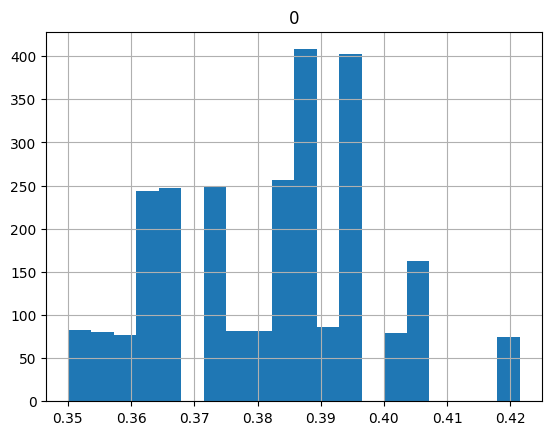

In [20]:
import pandas as pd
pd.DataFrame(np.concatenate(predictions, axis=None)).hist(bins = 20)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

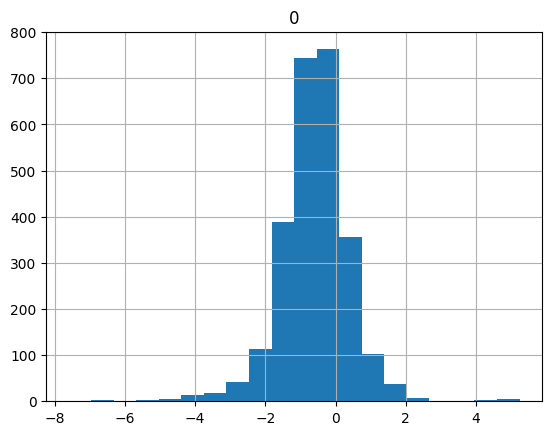

In [21]:
import pandas as pd
pd.DataFrame(np.concatenate(deepFM_predictions, axis=None)).hist(bins = 20)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

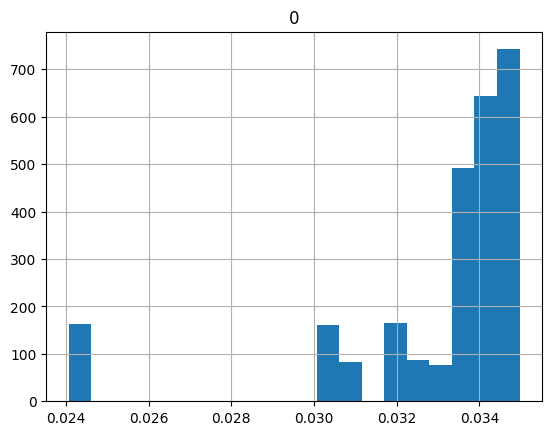

In [22]:
import pandas as pd
pd.DataFrame(np.concatenate([np.diag(x) for x in variances], axis = None)).hist(bins = 20)

array([[<AxesSubplot:title={'center':'0'}>]], dtype=object)

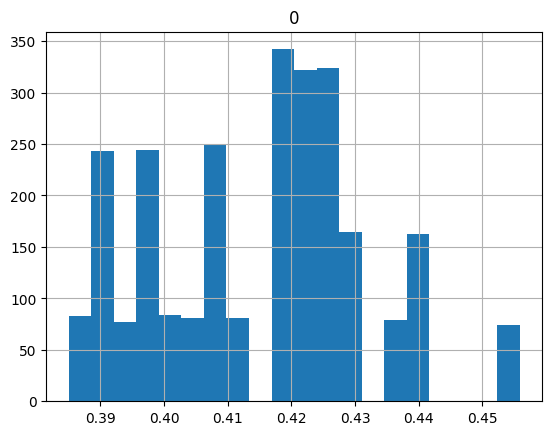

In [23]:
import pandas as pd
pd.DataFrame(np.concatenate([np.diag(x) for x in variances], axis = None) + np.concatenate(predictions, axis=None)).hist(bins = 20)

In [24]:
np.corrcoef(np.concatenate(predictions, axis=None), np.concatenate(deepFM_predictions, axis=None))[0, 1]

-0.012703900893928855

In [2]:
import pandas as pd

In [13]:
for i in range(100, 2300, 100):
    print(pd.read_pickle(f'tpfy/neural_linUCB_training_data/training_stats_run_{i}.pkl')['train_mse'])

0.23898169370567088
0.23709349966764157
0.23444925086636084
0.22646808379927647
0.23383521524608175
0.22658178462055198
0.2371701751503118
0.237906270683524
0.23558745882504456
0.24445420089695585
0.23804186899661298
0.23625438058798545
0.24410002832340916
0.24711590631818936
0.23696560200154523
0.23378922485588832
0.22574646728543074
0.24277938017458622
0.23789392505591198
0.23552834614778412
0.2633851542433758
0.23925557617634047


In [14]:
for i in range(100, 2300, 100):
    print(pd.read_pickle(f'tpfy/neural_linUCB_training_data/training_stats_run_{i}.pkl')['valid_mse'])

0.24493517165606482
0.2450395123453056
0.24475984719008365
0.24489745517232953
0.2449365674083451
0.24498153530610556
0.24508710268901052
0.2449246948854109
0.24496002531821257
0.2449603853533311
0.24492125487570346
0.2448765493068669
0.24485356510577477
0.24481115878506837
0.2448261638399419
0.2448585451427107
0.2448551102365321
0.2448243880552142
0.24485088206363775
0.24484065848837927
0.24484839916274778
0.2448119601242797


In [15]:
for i in range(100, 2300, 100):
    print(pd.read_pickle(f'tpfy/neural_linUCB_training_data/training_stats_run_{i}.pkl')['valid_popularity_variance_dist_stats']['mean'])

{'High': 0.047843091948421845, 'Low': 0.04898439550691642, 'Medium': 0.048414392656629605, 'Negligible': 0.05000129936189246}
{'High': 0.03493125407651411, 'Low': 0.03573349069158888, 'Medium': 0.03531196240948344, 'Negligible': 0.03644837494830821}
{'High': 0.028821502227898973, 'Low': 0.029467134127463376, 'Medium': 0.02911365790755281, 'Negligible': 0.030040777274258083}
{'High': 0.02509647733447536, 'Low': 0.02566344773288622, 'Medium': 0.025349685610372638, 'Negligible': 0.026151858519584282}
{'High': 0.022529582812692416, 'Low': 0.023038253277625622, 'Medium': 0.022754821311478476, 'Negligible': 0.023474977363143485}
{'High': 0.020621063691193892, 'Low': 0.02108418823896634, 'Medium': 0.02082385753835124, 'Negligible': 0.0214807860703627}
{'High': 0.019175837962544708, 'Low': 0.019606242723999, 'Medium': 0.019363829349380513, 'Negligible': 0.01997154552849689}
{'High': 0.018036285701460014, 'Low': 0.018439786305205503, 'Medium': 0.01821242048912859, 'Negligible': 0.01878218788890

In [8]:
for i in range(100, 1400, 100):
    print(pd.read_pickle(f'tpfy/neural_linUCB_training_data/training_stats_run_{i}.pkl')['valid_popularity_mean_dist_stats']['mean'])

{'High': 0.3884407916948841, 'Low': 0.3918883958008224, 'Medium': 0.3916854178794672, 'Negligible': 0.39092838758938886}
{'High': 0.3913461223847903, 'Low': 0.3901352282488649, 'Medium': 0.391915682618682, 'Negligible': 0.38953263137204536}
{'High': 0.3900972250210165, 'Low': 0.3915910650654012, 'Medium': 0.39344453736740564, 'Negligible': 0.3910111949844584}
{'High': 0.3910732822868451, 'Low': 0.3894146570024646, 'Medium': 0.3911451032837473, 'Negligible': 0.3885547028127606}
{'High': 0.3899596556312705, 'Low': 0.3890585315514594, 'Medium': 0.3890484831740729, 'Negligible': 0.3897382765667077}
{'High': 0.3889445049648792, 'Low': 0.3881011561560218, 'Medium': 0.38833840732054087, 'Negligible': 0.39084555581947106}
{'High': 0.3886632228106242, 'Low': 0.3881393799330605, 'Medium': 0.3876952704044692, 'Negligible': 0.38733816741188043}
{'High': 0.38915039931662515, 'Low': 0.3883928879874633, 'Medium': 0.38910460169588246, 'Negligible': 0.38838055560201334}
{'High': 0.3886248912984544, 'Lo

In [8]:
for i in range(100, 1400, 100):
    print(pd.read_pickle(f'tpfy/neural_linUCB_training_data/training_stats_run_{i}.pkl')['valid_popularity_mean_dist_stats']['mean'])

{'High': 0.3884407916948841, 'Low': 0.3918883958008224, 'Medium': 0.3916854178794672, 'Negligible': 0.39092838758938886}
{'High': 0.3913461223847903, 'Low': 0.3901352282488649, 'Medium': 0.391915682618682, 'Negligible': 0.38953263137204536}
{'High': 0.3900972250210165, 'Low': 0.3915910650654012, 'Medium': 0.39344453736740564, 'Negligible': 0.3910111949844584}
{'High': 0.3910732822868451, 'Low': 0.3894146570024646, 'Medium': 0.3911451032837473, 'Negligible': 0.3885547028127606}
{'High': 0.3899596556312705, 'Low': 0.3890585315514594, 'Medium': 0.3890484831740729, 'Negligible': 0.3897382765667077}
{'High': 0.3889445049648792, 'Low': 0.3881011561560218, 'Medium': 0.38833840732054087, 'Negligible': 0.39084555581947106}
{'High': 0.3886632228106242, 'Low': 0.3881393799330605, 'Medium': 0.3876952704044692, 'Negligible': 0.38733816741188043}
{'High': 0.38915039931662515, 'Low': 0.3883928879874633, 'Medium': 0.38910460169588246, 'Negligible': 0.38838055560201334}
{'High': 0.3886248912984544, 'Lo